In [1]:
import os 
import sys
sys.path.append(os.path.dirname(os.getcwd()))

import time
import random
from pprint import pprint
from glob import glob
import numpy as np
import pickle
import matplotlib.pyplot as plt
import cv2
from matplotlib.patches import FancyArrowPatch

import pyrender

import pygarment as pyg
import trimesh
import PIL
from PIL import Image

from analysis_utils import visualize_meshes_plotly, v_id_map, plot_panel_info

DATASET_ROOT_PATH = "/media/hjp/05aba9a7-0e74-4e54-9bc9-5f11b9c4c757/GarmentCodeData/"
GARMENT_ROOT_PATH = os.path.join(DATASET_ROOT_PATH, "GarmentCodeData_v2")
BODY_ROOT_PATH = os.path.join(DATASET_ROOT_PATH, "body_mesh")
MEAN_ALL_BODY_PATH = os.path.join(DATASET_ROOT_PATH, "neutral_body/mean_all.obj")

default_body_mesh = trimesh.load(MEAN_ALL_BODY_PATH)

print("body vertices", default_body_mesh.vertices.shape)
print("body faces", default_body_mesh.faces.shape)


# BODY_TYPE = "random_body"
BODY_TYPE = "default_body"

def fff(garment_path) :
    garment_id = os.path.basename(garment_path)
    if os.path.exists(
        os.path.join(garment_path, f"{garment_id}_fltrd_vis_seam_line_dict.pkl")
    ) and os.path.exists(
        os.path.join(garment_path, f"rendered_front.png")
    ):
        return True
    else :
        return False

garment_path_list = list(filter(
    fff,
    sorted(list(filter(
        os.path.isdir,
        glob(os.path.join(GARMENT_ROOT_PATH, "*", BODY_TYPE, "*"))
    )))
))

body vertices (23751, 3)
body faces (47500, 3)


In [2]:
print(len(garment_path_list))

1031


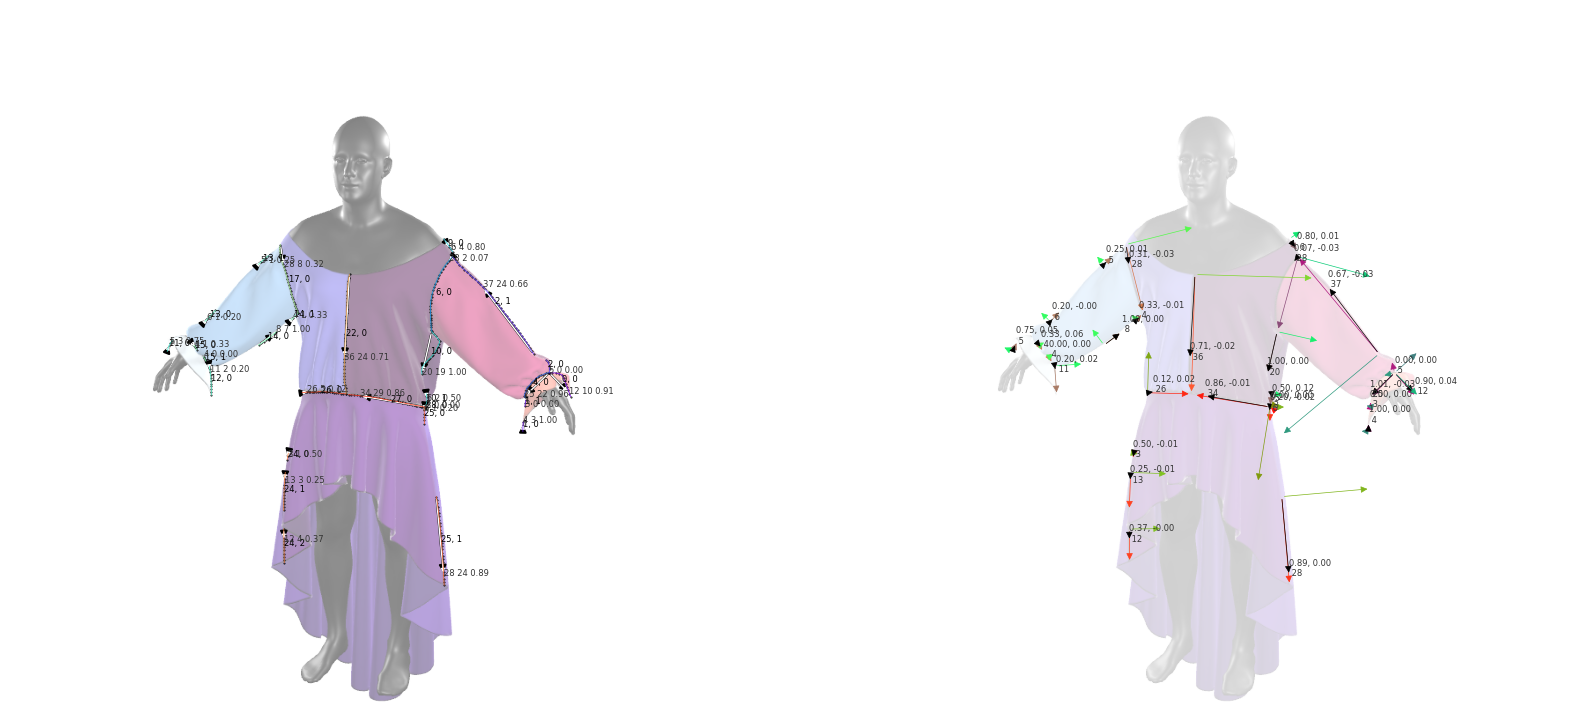

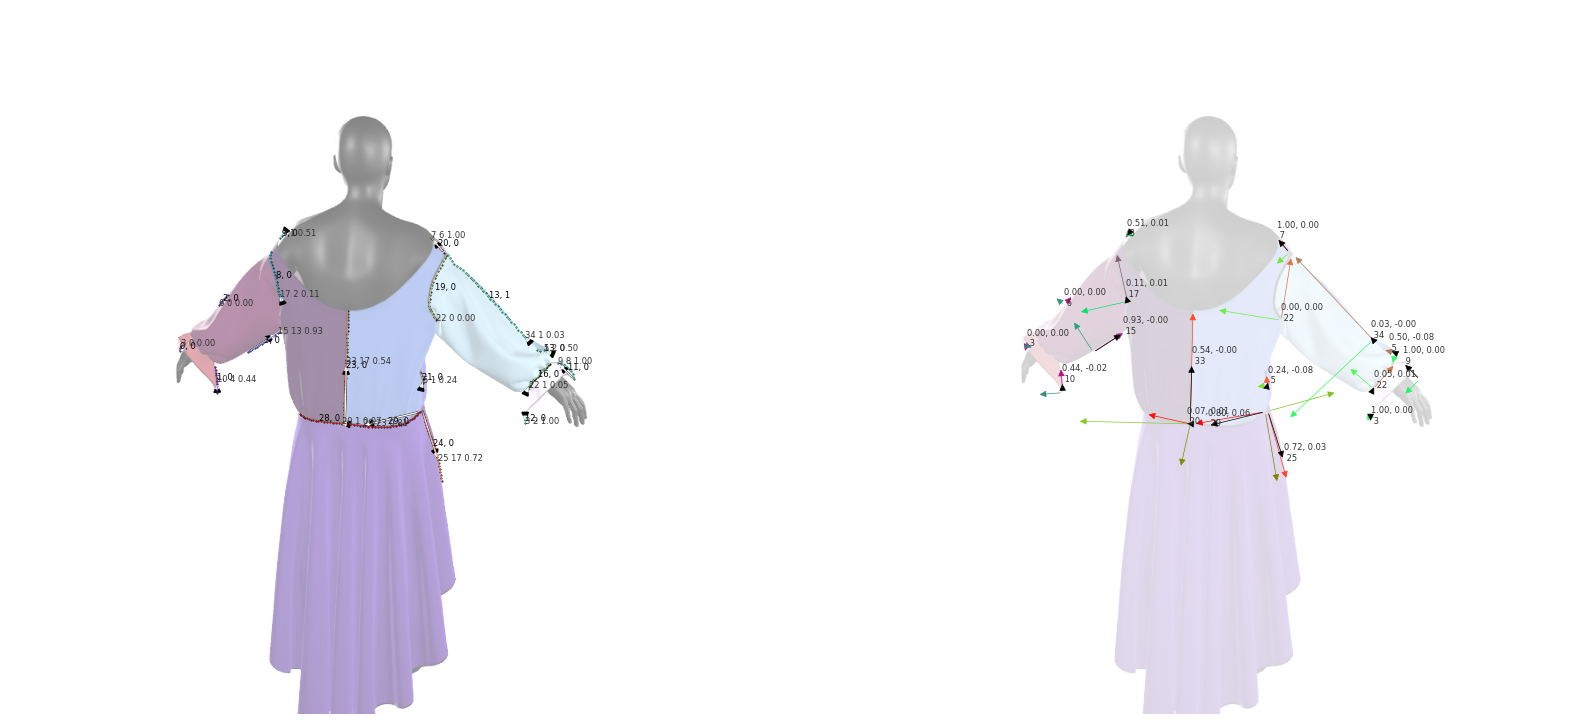

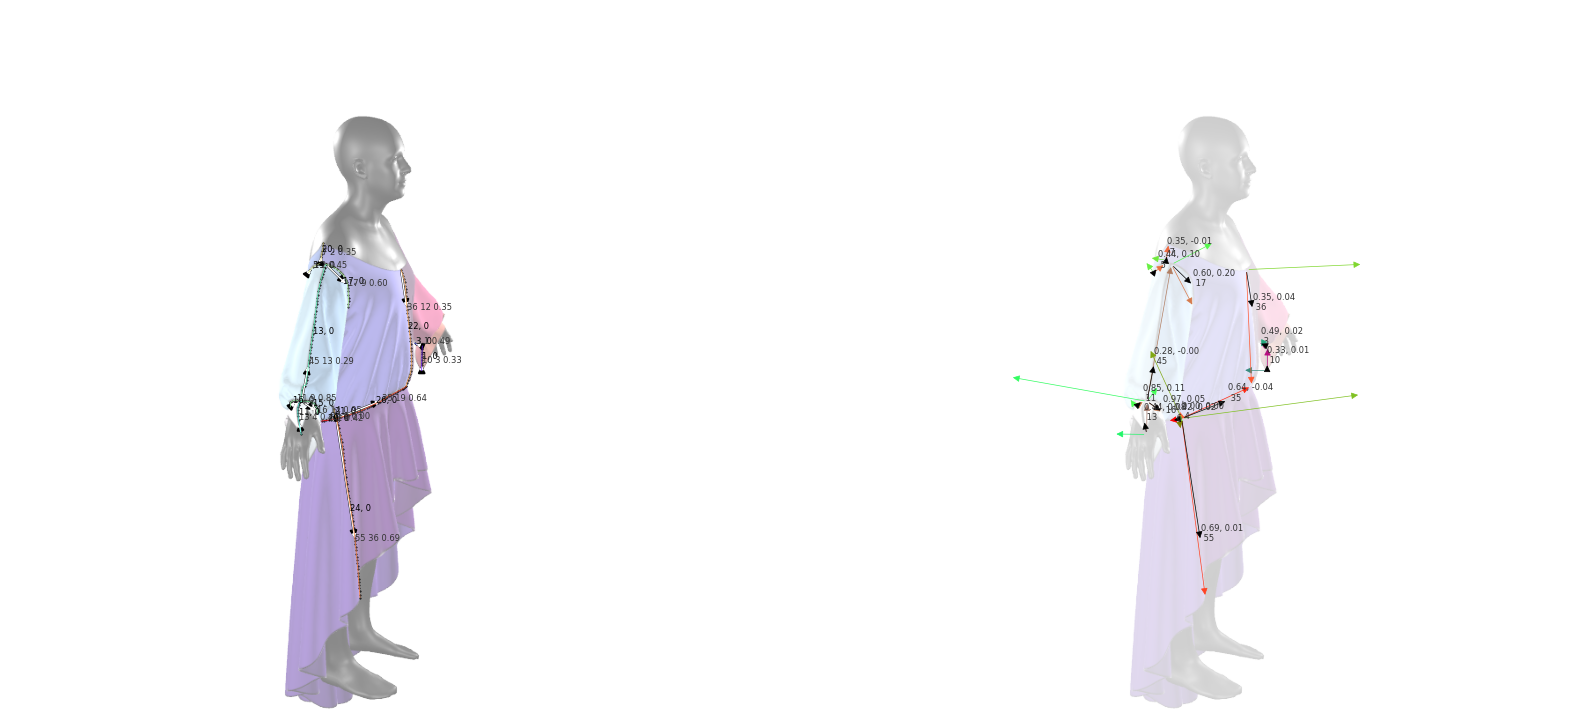

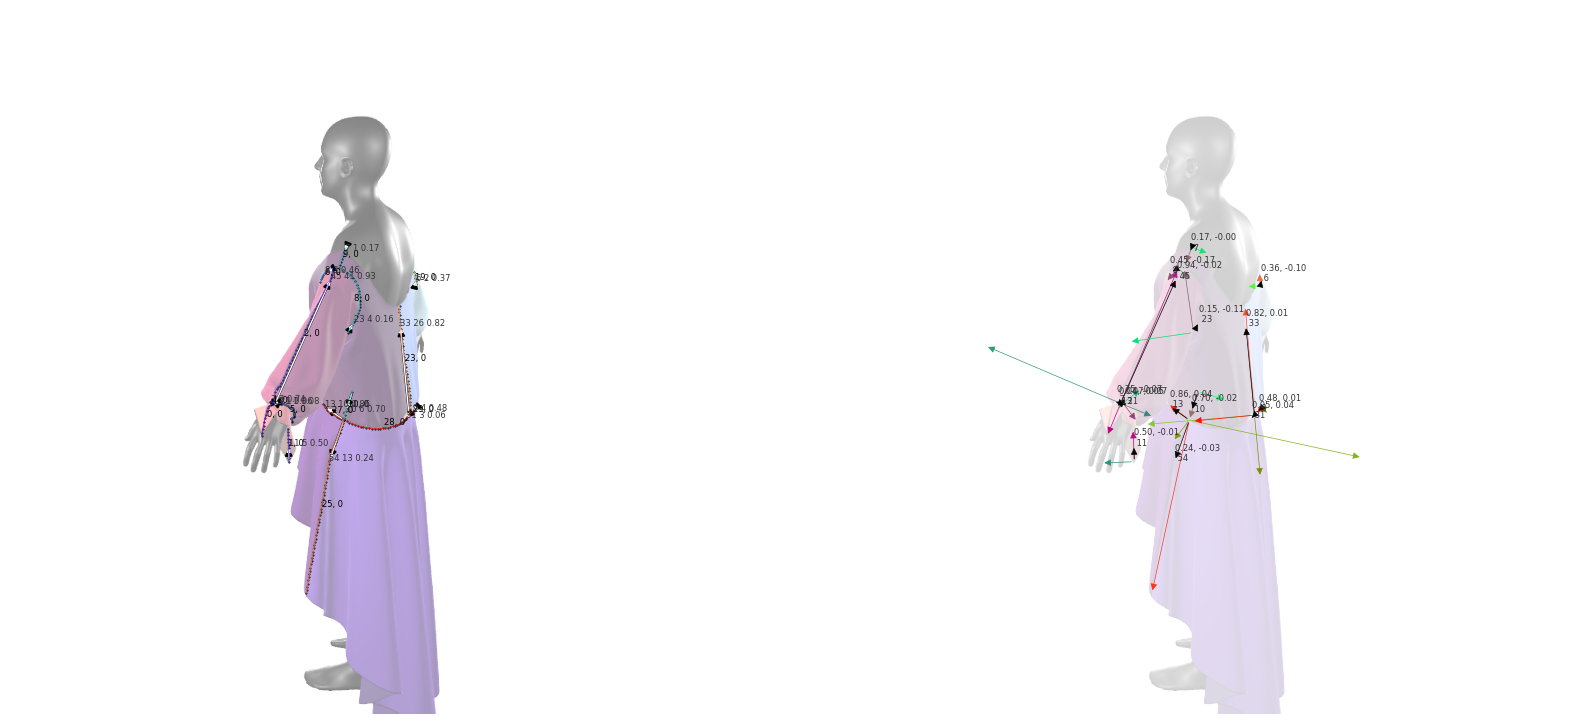

In [3]:
IDX = random.randint(0, len(garment_path_list) - 1)


garment_path = garment_path_list[IDX]
garment_id = os.path.basename(garment_path)


FIGLEN = 10
NROWS = 1
NCOLS = 2

rendered_image_dict = {}
for side in ["front", "back", "left", "right"] :
    rendered_image_dict[side] = Image.open(os.path.join(garment_path, f"rendered_{side}.png"))
    
with open(os.path.join(garment_path, f"{garment_id}_fltrd_vis_seam_line_dict.pkl"), "rb") as f :
    fltrd_vis_seam_line_dict = pickle.load(f)


STCH_IDX_MAX = max(list(map(
    lambda stch_dict : max(stch_dict.keys()),
    fltrd_vis_seam_line_dict.values()
)))
colors = plt.cm.rainbow(np.linspace(0, 1, STCH_IDX_MAX + 1))

for side in fltrd_vis_seam_line_dict.keys():
    plt.figure(figsize=(FIGLEN * NCOLS, FIGLEN))
    ax1 = plt.subplot(1, NCOLS, 1)
    ax1.imshow(rendered_image_dict[side], alpha=0.5)
    ax1.axis("off")
    
    ax2 = plt.subplot(1, NCOLS, 2)
    ax2.imshow(rendered_image_dict[side], alpha=0.2)
    ax2.axis("off")

    for seam_idx, seam_dict in fltrd_vis_seam_line_dict[side].items():
        for segment_idx, (
            segment_idx_arr, segment_pos_arr,
            segment_edge_len_arr, segment_t_arr,
            segment_u_arr, segment_v_arr
        ) in enumerate(zip(
            seam_dict["segment_idx_arr_list"],
            seam_dict["segment_pos_arr_list"],
            seam_dict["segment_edge_len_arr_list"],
            seam_dict["segment_t_arr_list"],
            seam_dict["segment_u_arr_list"],
            seam_dict["segment_v_arr_list"]
        )):
            
            i_vec = segment_pos_arr[-1] - segment_pos_arr[0]
            j_vec = np.array([i_vec[1], -i_vec[0]])
            
            
            # print(
            #     len(segment_idx_arr), len(segment_pos_arr),
            #     len(edge_len_arr), len(t_arr),
            #     len(u_arr), len(v_arr)
            # )
            
            ax1.annotate(
                f"{seam_idx}, {segment_idx}",
                xy = (segment_pos_arr.mean(axis=0)),
                xytext = (segment_pos_arr.mean(axis=0)),
                fontsize=6
            )
            ax1.plot(
                segment_pos_arr[:, 0],
                segment_pos_arr[:, 1],
                '-',
                color=colors[seam_idx],
                linewidth=0.5
            )
            ax1.scatter(
                segment_pos_arr[:, 0],
                segment_pos_arr[:, 1],
                color="black",
                s=0.2
            )
            
            
            arrow_i = FancyArrowPatch(
                segment_pos_arr[0], segment_pos_arr[0] + i_vec,
                arrowstyle='-|>',
                mutation_scale=10,
                color=np.mean(
                    [colors[seam_idx], np.array([1, 0, 0, 1])],
                    axis=0
                ),
                linewidth=0.5
            )
            
            arrow_j = FancyArrowPatch(
                segment_pos_arr[0], segment_pos_arr[0] + j_vec,
                arrowstyle='-|>',
                mutation_scale=10,
                color=np.mean(
                    [colors[seam_idx], np.array([0, 1, 0, 1])],
                    axis=0
                ),
                linewidth=0.5
            )
            ax2.add_patch(arrow_i)
            ax2.add_patch(arrow_j)
            
            random_idx = random.randint(0, len(segment_pos_arr) - 1)
            t = segment_t_arr[random_idx]
            u = segment_u_arr[random_idx]
            v = segment_v_arr[random_idx]
            
            ax1.annotate(
                f"{len(segment_pos_arr)} {random_idx} {t:.2f}",
                xy = (segment_pos_arr[random_idx]),
                xytext = (segment_pos_arr[random_idx]),
                fontsize=6, color=(0.2, 0.2, 0.2, 1)
            )
            
            arrow_1 = FancyArrowPatch(
                segment_pos_arr[0], segment_pos_arr[random_idx],
                arrowstyle='-|>',
                mutation_scale=10,
                color='black',
                linewidth=1.5
            )
            arrow_2 = FancyArrowPatch(
                segment_pos_arr[0],
                segment_pos_arr[0] + u * i_vec + v * j_vec,
                arrowstyle='-|>',
                mutation_scale=5,
                color='white',
                linewidth=1
            )
            ax1.add_patch(arrow_1)
            ax1.add_patch(arrow_2)
            
            
            ax2.annotate(
                f"{u:.2f}, {v:.2f} \n {len(segment_t_arr)}",
                xy = (segment_pos_arr[random_idx]),
                xytext = (segment_pos_arr[random_idx]),
                fontsize=6, color=(0.2, 0.2, 0.2, 1)
            )
            
            arrow_2 = FancyArrowPatch(
                segment_pos_arr[0],
                segment_pos_arr[0] + u * i_vec + v * j_vec,
                arrowstyle='-|>',
                mutation_scale=10,
                color='black',
                linewidth=0.5
            )
            ax2.add_patch(arrow_2)